In [1]:
from sklearn.linear_model import Ridge,Lasso
import xgboost as xgb
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-car-price-prediction/car_web_scraped_dataset.csv


# Loading Data

In [2]:
df = pd.read_csv('/kaggle/input/used-car-price-prediction/car_web_scraped_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840 entries, 0 to 2839
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       2840 non-null   object
 1   year       2840 non-null   int64 
 2   miles      2840 non-null   object
 3   color      2840 non-null   object
 4   condition  2840 non-null   object
 5   price      2840 non-null   object
dtypes: int64(1), object(5)
memory usage: 133.2+ KB


# Preprocessing & Statistics

In [3]:
#preview sample of data to see what preprocess should handle
df.head(20)

,name,year,miles,color,condition,price
0,Kia Forte,2022,"41,406 miles","Gray exterior, Black interior","No accidents reported, 1 Owner","$15,988"
1,Chevrolet Silverado 1500,2021,"15,138 miles","White exterior, Black interior","1 accident reported, 1 Owner","$38,008"
2,Toyota RAV4,2022,"32,879 miles","Silver exterior, Unknown interior","No accidents reported, 1 Owner","$24,988"
3,Honda Civic,2020,"37,190 miles","Blue exterior, Black interior","No accidents reported, 1 Owner","$18,998"
4,Honda Civic,2020,"27,496 miles","Black exterior, Black interior","No accidents reported, 1 Owner","$19,498"
5,Honda Civic,2020,"29,026 miles","Silver exterior, Black interior","1 accident reported, 1 Owner","$21,000"
6,Honda Accord,2019,"4,148 miles","Black exterior, Black interior","1 accident reported, 1 Owner","$20,998"
7,Mercedes-Benz GLC,2018,"57,602 miles","Blue exterior, Unknown interior","1 accident reported, 3 Owners","$18,887"
8,Honda Civic,2020,"50,240 miles","Black exterior, Black interior","1 accident reported, 1 Owner","$19,498"
9,BMW 5 Series,2013,"56,766 miles","White exterior, Black interior","No accidents reported, 3 Owners","$17,998"


In [4]:
#check unique values in condition
df['condition'].value_counts()

condition
No accidents reported, 1 Owner     1575
No accidents reported, 2 Owners     426
1 accident reported, 1 Owner        236
1 accident reported, 2 Owners       157
No accidents reported, 3 Owners     152
1 accident reported, 3 Owners        58
2 accidents reported, 1 Owner        43
No accidents reported, 4 Owners      41
2 accidents reported, 2 Owners       30
2 accidents reported, 3 Owners       26
1 accident reported, 4 Owners        17
No accidents reported, 0 Owners      13
2 accidents reported, 4 Owners       12
No accidents reported, 5 Owners      11
1 accident reported, 5 Owners        10
3 accidents reported, 1 Owner         9
4 accidents reported, 3 Owners        5
3 accidents reported, 2 Owners        4
3 accidents reported, 3 Owners        3
No accidents reported, 7 Owners       3
3 accidents reported, 4 Owners        2
5 accidents reported, 5 Owners        2
No accidents reported, 8 Owners       2
2 accidents reported, 5 Owners        2
4 accidents reported, 2 Owners

In [5]:
#remove miles from column miles and transform it to float datatype
df['miles']=df['miles'].replace('miles', '', regex=True)
df['miles']=df['miles'].replace(',', '', regex=True)
df['miles']=df['miles'].astype(float)
#remove $ from column Price and transform it to float datatype
df['price']=df['price'].str.replace('$', '')
df['price']=df['price'].replace(',', '', regex=True)
df['price']=df['price'].astype(float)
#replace 'accidents reported' into ,
df['condition']=df['condition'].replace('accidents reported,', ',', regex=True)
#replace 'accident reported' into ,
df['condition']=df['condition'].replace('accident reported,', ',', regex=True)
#replace 'No' into zero
df['condition']=df['condition'].replace('No', '0', regex=True)
#replace 'Owner' into empty
df['condition']=df['condition'].replace('Owners', '', regex=True)
#replace 'Owner' into empty
df['condition']=df['condition'].replace('Owner', '', regex=True)
# Split the 'ColumnWithCommas' into two columns based on ','
df[['accidents', 'Owners']] = df['condition'].str.split(',', expand=True)
df['accidents']=df['accidents'].astype(int)
df['Owners']=df['Owners'].astype(int)

In [6]:
#recheck dataframe after preprocessing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840 entries, 0 to 2839
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       2840 non-null   object 
 1   year       2840 non-null   int64  
 2   miles      2840 non-null   float64
 3   color      2840 non-null   object 
 4   condition  2840 non-null   object 
 5   price      2840 non-null   float64
 6   accidents  2840 non-null   int64  
 7   Owners     2840 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 177.6+ KB


In [7]:
#Check nulls and unique values
for col in df.columns:
    print("column",col,"null values:",df[col].isnull().sum())
    print("column",col,"uniques counts:",df[col].nunique())
    print("------------------------------------------------")

column name null values: 0
column name uniques counts: 309
------------------------------------------------
column year null values: 0
column year uniques counts: 24
------------------------------------------------
column miles null values: 0
column miles uniques counts: 2280
------------------------------------------------
column color null values: 0
column color uniques counts: 64
------------------------------------------------
column condition null values: 0
column condition uniques counts: 25
------------------------------------------------
column price null values: 0
column price uniques counts: 1245
------------------------------------------------
column accidents null values: 0
column accidents uniques counts: 6
------------------------------------------------
column Owners null values: 0
column Owners uniques counts: 8
------------------------------------------------


In [8]:
#extract mark from name
df['mark'] = df['name'].str.split(' ', expand=True)[0]

In [9]:
df.describe()

,year,miles,price,accidents,Owners
count,2840.000000,2840.000000,2840.000000,2840.000000,2840.000000
mean,2018.833803,50138.445775,25745.427465,0.278873,1.507394
std,3.557585,36482.439893,13627.610019,0.598558,0.866146
min,2000.000000,25.000000,4395.000000,0.000000,0.000000
25%,2017.000000,23233.750000,17851.000000,0.000000,1.000000
50%,2020.000000,41076.000000,23000.000000,0.000000,1.000000
75%,2021.000000,70978.250000,31222.500000,0.000000,2.000000
max,2024.000000,307292.000000,252900.000000,5.000000,8.000000


# Categorical Outliers

In [10]:
def remove_Noutliers(col,threshold):
    category_counts = df[col].value_counts()

    # Set a threshold for low frequency
    uncommon_categories = category_counts[category_counts < threshold].index.tolist()
    # Identify rows with uncommon categories
    outliers = df[df[col].isin(uncommon_categories)]
    print("Column=",col)
    print("unique values=",len(df[col].value_counts()))
    print("Threshold=",threshold)
    print("outliers=",len(outliers))
    print("all=",len(df[col]))
    print("outlier percentages=",round(len(outliers)/len(df[col]),2) * 100 ,"%")
    print("-------------------------")
    return df[~df[col].isin(uncommon_categories)]

   
total_len = len(df)    
df = remove_Noutliers('year',10)
df = remove_Noutliers('accidents',50)
df = remove_Noutliers('Owners',20)
print("outlier removed=",str((total_len - len(df))/100),"%")

Column= year
unique values= 24
Threshold= 10
outliers= 28
all= 2840
outlier percentages= 1.0 %
-------------------------
Column= accidents
unique values= 6
Threshold= 50
outliers= 25
all= 2812
outlier percentages= 1.0 %
-------------------------
Column= Owners
unique values= 7
Threshold= 20
outliers= 14
all= 2787
outlier percentages= 1.0 %
-------------------------
outlier removed= 0.67 %


# Numeric Outliers

Q1= 23045.0 , Q3= 69058.0 , lower= -45974.5 , upper= 138077.5
Q1= 17998.0 , Q3= 31990.0 , lower= -2990.0 , upper= 52978.0
outlier removed= 1.36 %


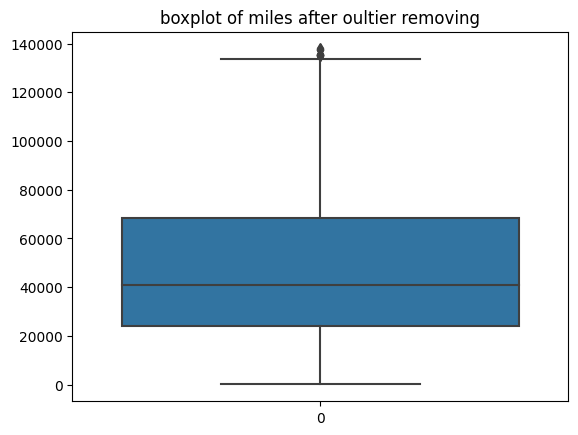

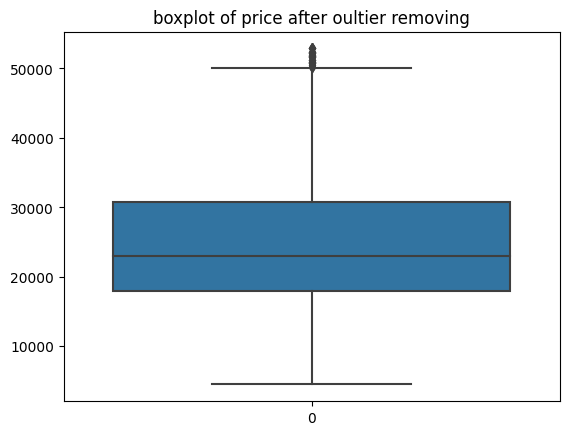

In [11]:
def remove_outliers(c):
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print("Q1=",Q1,", Q3=",Q3,", lower=",lower_bound,", upper=",upper_bound)
    # Filter the DataFrame to exclude outliers
    return df[(df[c] >= lower_bound) & (df[c] <= upper_bound)]

total_len = len(df)
df = remove_outliers('miles')
df = remove_outliers('price')
print("outlier removed=",str((total_len - len(df))/100),"%")
for c in ['miles','price']:
    sns.boxplot(df[c])
    plt.title("boxplot of "+c+" after oultier removing")
    plt.show()

# Single Column EDAs

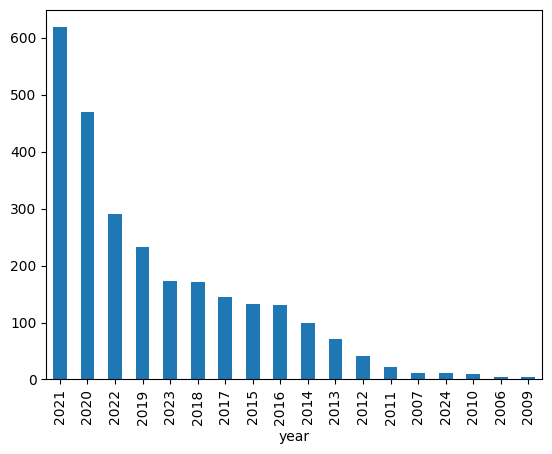

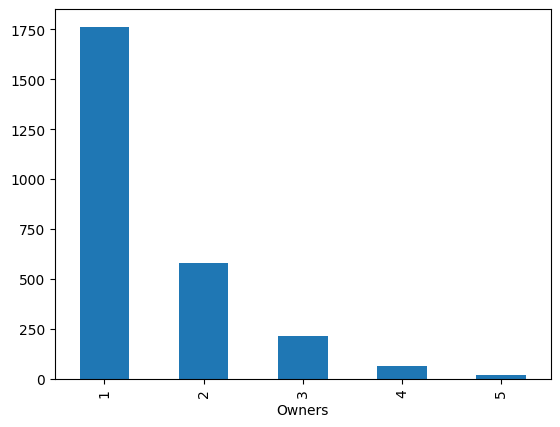

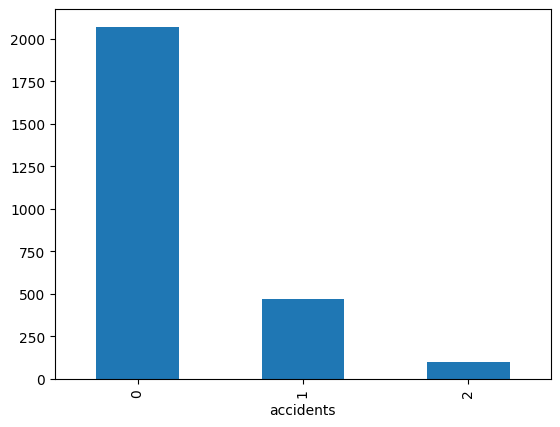

In [12]:
#Count plot for cars per year, owner, and accident
col= ['year','Owners','accidents']
for c in col:
    df[c].value_counts().plot(kind='bar')
    plt.show()

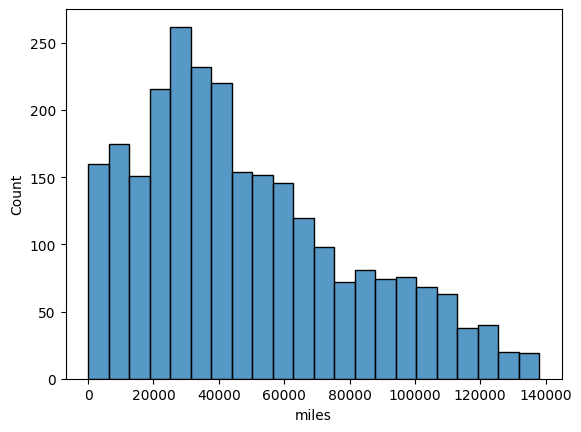

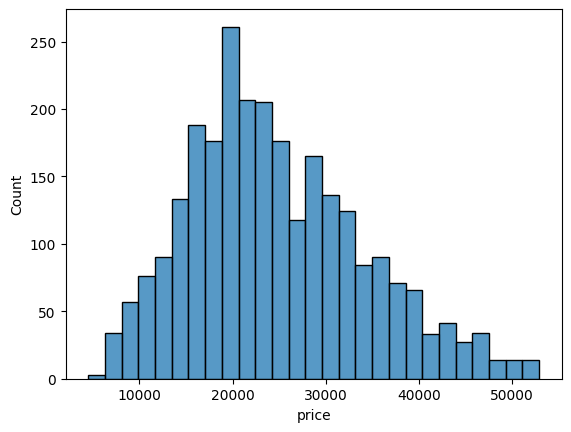

In [13]:
for c in ['miles','price']:
    sns.histplot(df[c])
    plt.show()

# Grouped Columns EDAs

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, '2006'),
  Text(1, 0, '2007'),
  Text(2, 0, '2009'),
  Text(3, 0, '2010'),
  Text(4, 0, '2011'),
  Text(5, 0, '2012'),
  Text(6, 0, '2013'),
  Text(7, 0, '2014'),
  Text(8, 0, '2015'),
  Text(9, 0, '2016'),
  Text(10, 0, '2017'),
  Text(11, 0, '2018'),
  Text(12, 0, '2019'),
  Text(13, 0, '2020'),
  Text(14, 0, '2021'),
  Text(15, 0, '2022'),
  Text(16, 0, '2023'),
  Text(17, 0, '2024')])

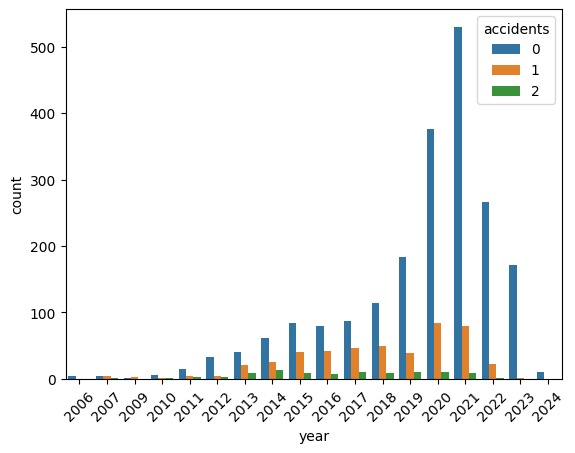

In [14]:
sns.countplot(x='year',data=df,hue='accidents')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, '2006'),
  Text(1, 0, '2007'),
  Text(2, 0, '2009'),
  Text(3, 0, '2010'),
  Text(4, 0, '2011'),
  Text(5, 0, '2012'),
  Text(6, 0, '2013'),
  Text(7, 0, '2014'),
  Text(8, 0, '2015'),
  Text(9, 0, '2016'),
  Text(10, 0, '2017'),
  Text(11, 0, '2018'),
  Text(12, 0, '2019'),
  Text(13, 0, '2020'),
  Text(14, 0, '2021'),
  Text(15, 0, '2022'),
  Text(16, 0, '2023'),
  Text(17, 0, '2024')])

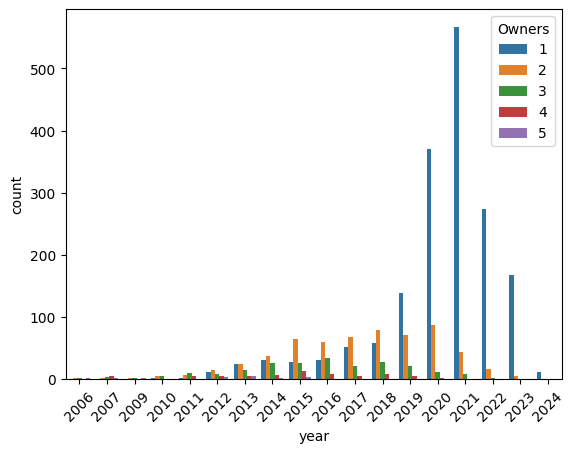

In [15]:
sns.countplot(x='year',data=df,hue='Owners')
plt.xticks(rotation=45)

In [16]:
# Aggregate 'accidents' by 'year'
df_agg = df.groupby(['year'])[['accidents','Owners']].sum().reset_index()
df_agg

,year,accidents,Owners
0,2006,0,15
1,2007,9,43
2,2009,3,15
3,2010,5,21
4,2011,10,61
5,2012,11,98
6,2013,39,154
7,2014,51,211
8,2015,58,297
9,2016,58,279


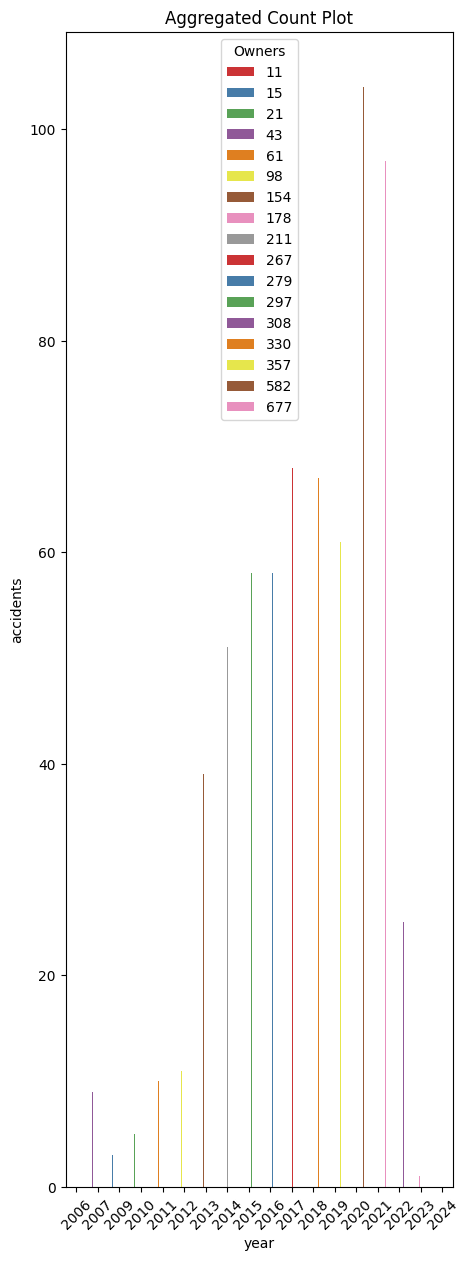

In [17]:
# Create a count plot
plt.figure(figsize=(5,15))
sns.barplot(x='year', y='accidents', hue='Owners', data=df_agg, palette='Set1')
plt.title('Aggregated Count Plot')
plt.xticks(rotation=45)
plt.show()

# Statitical plots

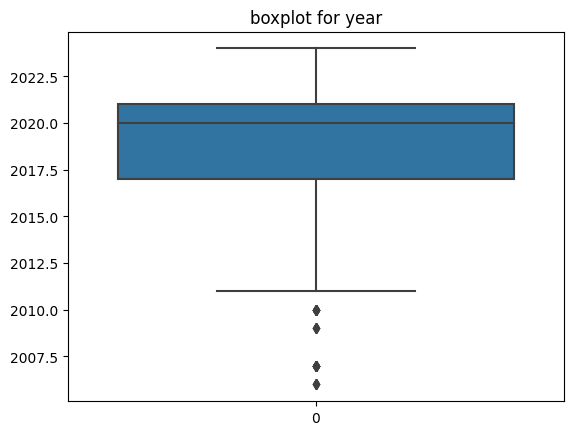

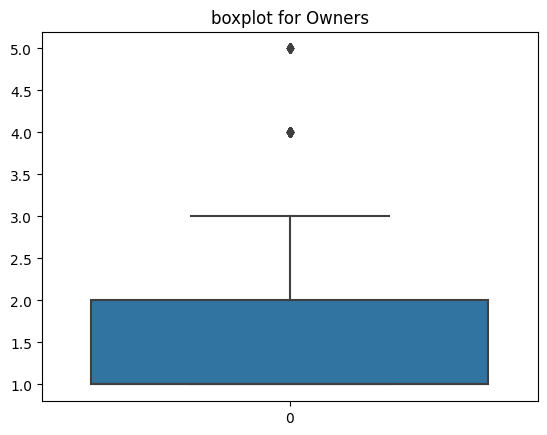

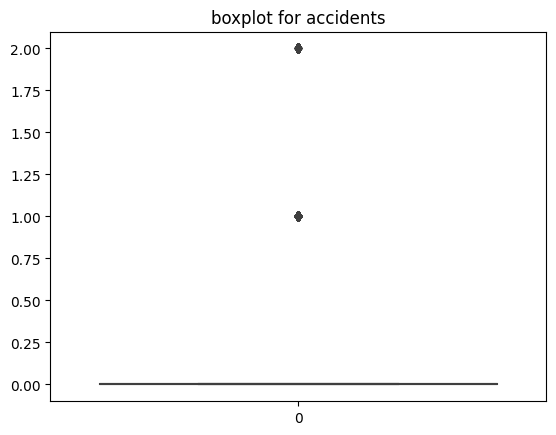

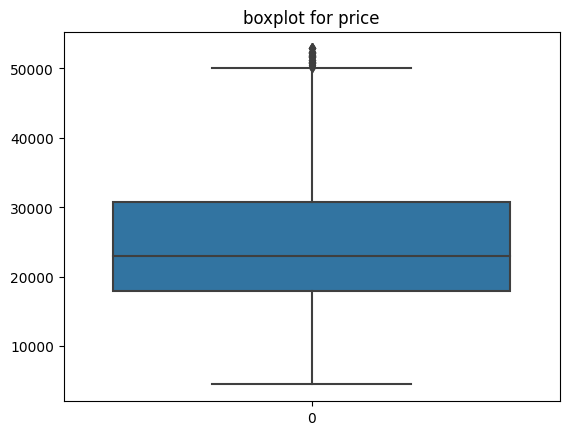

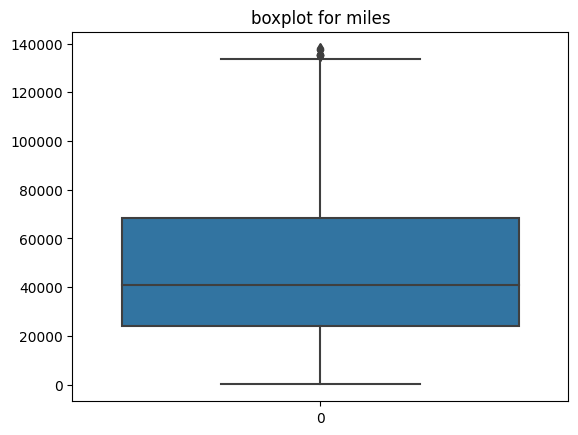

In [18]:
for c in ['year','Owners','accidents','price','miles']:
    sns.boxplot(df[c])
    plt.title("boxplot for "+c)
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    plt.show()

# Numerical Data

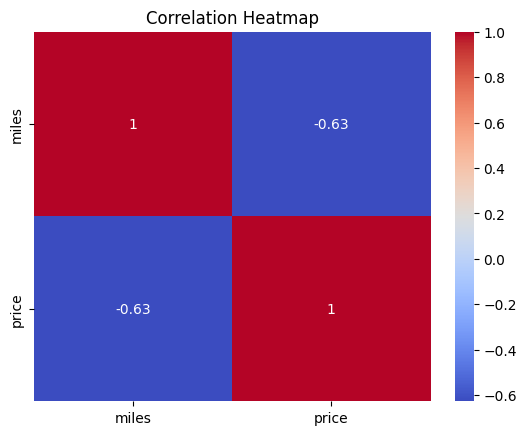

In [19]:
correlation_matrix = df[['miles','price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# Identify highly correlated columns
highly_correlated_vars = set()

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.index:
        # Check if col1 and col2 are different before adding to the set
        if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8 and (col2, col1) not in highly_correlated_vars:
            highly_correlated_vars.add((col1, col2))

# Convert the set to a list
highly_correlated_vars_list = list(highly_correlated_vars)

print("Highly Correlated Variables:")
print(highly_correlated_vars_list)

# Identify weakly correlated columns
weakly_correlated_vars = set()

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.index:
        # Check if col1 and col2 are different before adding to the set
        if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) < 0.5 and (col2, col1) not in weakly_correlated_vars:
            weakly_correlated_vars.add((col1, col2))

# Convert the set to a list
weakly_correlated_vars_list = list(weakly_correlated_vars)

print("\nWeakly Correlated Variables:")
print(weakly_correlated_vars_list)

Highly Correlated Variables:
[]

Weakly Correlated Variables:
[]


In [21]:
#Cramér's V is a measure of association between two categorical variables. 
#It ranges from 0 to 1, with 0 indicating no association and 1 indicating a perfect association.
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v_value = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return cramers_v_value

# Example usage
for c in ["year","Owners","accidents"]:
    for d in ["year","Owners","accidents"]:
        if c!=d:
            cramers_v_value = cramers_v(df[c], df[d])
            print(c,"and",d)
            print(f"Cramér's V Value: {cramers_v_value}")

year and Owners
Cramér's V Value: 0.37804989552188417
year and accidents
Cramér's V Value: 0.21615055893258095
Owners and year
Cramér's V Value: 0.3780498955218841
Owners and accidents
Cramér's V Value: 0.16885542554409144
accidents and year
Cramér's V Value: 0.21615055893258092
accidents and Owners
Cramér's V Value: 0.16885542554409147


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Variables with high VIF values (typically above 5 or 10) may indicate multicollinearity.
# Assuming 'X' is your design matrix (independent variables)
vif_data = pd.DataFrame()
vif_data["Variable"] = df[['year','miles','accidents','Owners']].columns
vif_data["VIF"] = [variance_inflation_factor(df[['year','miles','accidents','Owners']].values, i) for i in range(df[['year','miles','accidents','Owners']].shape[1])]
vif_data

,Variable,VIF
0,year,4.868124
1,miles,4.364102
2,accidents,1.338672
3,Owners,5.968357


In [23]:
from scipy.stats import spearmanr

# Example data
independent_variable = df[['year','miles','accidents','Owners']]
dependent_variable = df[['price']]

# Calculate Spearman correlation coefficient
rho, p_value = spearmanr(independent_variable, dependent_variable)

print(f"Spearman Correlation Coefficient: \n",np.round(rho,2))
print(f"P-value: \n",np.round(p_value,2))

Spearman Correlation Coefficient: 
 [[ 1.   -0.74 -0.28 -0.59  0.58]
 [-0.74  1.    0.26  0.5  -0.65]
 [-0.28  0.26  1.    0.22 -0.21]
 [-0.59  0.5   0.22  1.   -0.4 ]
 [ 0.58 -0.65 -0.21 -0.4   1.  ]]
P-value: 
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


* Pearson correlation includes both variables, and it assesses linear relationships.
* Spearman correlation includes both variables, and it assesses monotonic relationships.
* All linear relationships are monotonic, but not all monotonic relationships are linear. A monotonic relationship indicates a consistent directional trend, while a linear relationship specifically refers to a proportional change represented by a straight line.
* When calculating the Variance Inflation Factor (VIF), you do not include the dependent variable (target variable) because VIF is specifically designed to assess multicollinearity among independent variables in a regression model.

# Scaler and PCA

In [24]:
scaler = MinMaxScaler()
df[['year','miles','accidents','Owners','price']] = scaler.fit_transform(df[['year','miles','accidents','Owners','price']])

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df[['year','miles','accidents','Owners']])

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Linear Regression

In [25]:
X = principalDf
y = df[['price']]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.02329053518023622


# Random Forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

# Make predictions for the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.024580151987078504


/tmp/ipykernel_18/3357852153.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


# Ridge Resgression

In [27]:
ridge_model = Ridge(alpha=1.0)  # You can adjust the alpha (regularization strength) parameter

# Fit the model on the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.023286265401419176


# Lasso Regression

In [28]:
# Create Lasso Regression model
lasso_model = Lasso(alpha=1.0)  # You can adjust the alpha (regularization strength) parameter

# Fit the model on the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error (Lasso): {mse_lasso}')

Mean Squared Error (Lasso): 0.038069438855097684


# XGBoost Regressor

In [29]:
# Convert data to DMatrix format used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'alpha': 10}

# Train XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(dtest)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Mean Squared Error (XGBoost): {mse_xgb}')

Mean Squared Error (XGBoost): 0.0226666555349453
